In [6]:
import pandas as pd

In [33]:
from google.colab import files
import pandas as pd

# Upload the file
uploaded = files.upload()  # this will open a file chooser

# Then read the uploaded file (use the exact name of your CSV)
df = pd.read_csv("sea_levels_2015.csv")
print(df.head())



Saving sea_levels_2015.csv to sea_levels_2015 (1).csv
         Time   GMSL  GMSL uncertainty
0  1880-01-15 -183.0              24.2
1  1880-02-15 -171.1              24.2
2  1880-03-15 -164.3              24.2
3  1880-04-15 -158.2              24.2
4  1880-05-15 -158.7              24.2


In [34]:
print(df.isnull().sum())   # count missing values in each column



Time                0
GMSL                0
GMSL uncertainty    0
dtype: int64


In [35]:
# Drop rows with missing values
df = df.dropna()


In [36]:
# Fill numeric columns with mean
df[df.select_dtypes(include=['float64','int64']).columns] = df.select_dtypes(include=['float64','int64']).fillna(df.mean(numeric_only=True))

# Fill categorical columns with last known value
df[df.select_dtypes(exclude=['float64','int64']).columns] = df.select_dtypes(exclude=['float64','int64']).fillna(method='ffill')


/tmp/ipython-input-4040705820.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[df.select_dtypes(exclude=['float64','int64']).columns] = df.select_dtypes(exclude=['float64','int64']).fillna(method='ffill')


In [37]:
print(df.columns)



Index(['Time', 'GMSL', 'GMSL uncertainty'], dtype='object')


In [38]:
df.shape

(1608, 3)

In [39]:
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df = df.sort_values('Time')

# Set index as Time
df = df.set_index('Time')

# Resample monthly and interpolate missing values
df = df.resample('M').mean().interpolate()

print(df.head())

             GMSL  GMSL uncertainty
Time                               
1880-01-31 -183.0              24.2
1880-02-29 -171.1              24.2
1880-03-31 -164.3              24.2
1880-04-30 -158.2              24.2
1880-05-31 -158.7              24.2


/tmp/ipython-input-517055609.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').mean().interpolate()


In [40]:
data = df[['GMSL']].values


In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


In [42]:
import numpy as np

def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 12   # past 12 months
X, y = create_sequences(data_scaled, SEQ_LEN)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1596, 12, 1)
y shape: (1596, 1)


In [43]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(SEQ_LEN, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
history = model.fit(X_train, y_train, epochs=35, batch_size=16, validation_split=0.1)


Epoch 1/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0160 - val_loss: 4.7921e-04
Epoch 2/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.0513e-04 - val_loss: 6.4998e-04
Epoch 3/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1346e-04 - val_loss: 5.7418e-04
Epoch 4/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.3055e-04 - val_loss: 4.9808e-04
Epoch 5/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8717e-04 - val_loss: 4.0292e-04
Epoch 6/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.2598e-04 - val_loss: 3.9746e-04
Epoch 7/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1949e-04 - val_loss: 4.2080e-04
Epoch 8/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5221e-04 - val_loss: 3.7257e-04
Epoch 9/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5539e-04 - val_loss: 4.2127e-04
Epoch 10/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2037e-04 - val_loss: 3.4766e-04
Epoch 11/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7793e-04 - val_los

In [46]:
y_pred = model.predict(X_test)

# Reverse scaling
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

print("Real:", y_test_rescaled[:5].flatten())
print("Pred:", y_pred_rescaled[:5].flatten())


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Real: [-10.9  -9.3  -8.2 -13.5 -15.3]
Pred: [-14.589626 -14.292567 -13.353855 -12.344892 -14.573193]


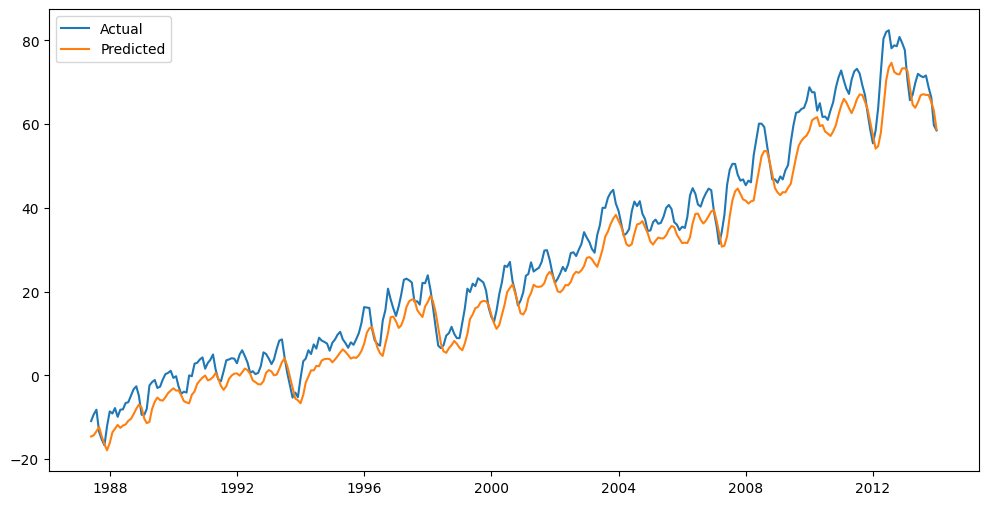

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test_rescaled, label="Actual")
plt.plot(df.index[-len(y_test):], y_pred_rescaled, label="Predicted")
plt.legend()
plt.show()


In [48]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# MAE
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

# Mean of actual values
mean_actual = np.mean(y_test_rescaled)

# Accuracy %
accuracy = 100 * (1 - mae / mean_actual)

print(f"Model Accuracy: {accuracy:.2f}%")


Model Accuracy: 83.03%


In [49]:
model.save("lstm_gmsl_model.h5")

In [50]:
from google.colab import files
files.download("lstm_gmsl_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)

In [52]:
# Save weights with correct extension
model.save_weights("lstm_model.weights.h5")

print("✅ Model weights saved successfully")


✅ Model weights saved successfully


In [54]:
from tensorflow.keras.models import load_model
import tensorflow.keras.losses as losses

# Load model and tell Keras what 'mse' is
model = load_model("lstm_gmsl_model.h5", custom_objects={'mse': losses.MeanSquaredError()})


In [56]:
model = load_model("lstm_gmsl_model.h5", compile=False)


In [57]:
model.compile(optimizer='adam', loss='mse')


In [64]:
import numpy as np

# Replace these values with your actual input features
raw_input = np.array([[0.5, 1.2, 3.4]])


In [66]:
print("Model input shape:", model.input_shape)



Model input shape: (None, 12, 1)


In [68]:
import numpy as np

# Your 12-step sequence (1 feature per timestep)
raw_input = np.array([0.5, 0.6, 0.55, 0.58, 0.6, 0.62, 0.63, 0.64, 0.66, 0.68, 0.7, 0.72])

# Reshape to (timesteps, features) = (12,1) for the scaler
raw_input = raw_input.reshape(-1, 1)  # 12 rows, 1 column

# Scale
input_scaled = scaler.transform(raw_input)

# Reshape for LSTM: (samples, timesteps, features) = (1, 12, 1)
input_scaled = input_scaled.reshape(1, 12, 1)

# Predict
prediction = model.predict(input_scaled)
print("Prediction:", prediction[0][0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Prediction: 0.68197584
